# Contents and why we need this lab

This lab is about implementing neural networks yourself before we start using other frameworks which hide some of the computation from you. It builds on the first lab where you derived the equations for neural network forward and backward propagation and gradient descent parameter updates. 

All the frameworks for deep learning you will meet from now on uses automatic differentiation (autodiff) so you don't have to code the backward step yourself. In this version of this lab you will develop your own autodif implementation. We also have a [version](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/2_Feedforward_NumPy/2.1-FNN-NumPy.ipynb) of this lab where you have to code the backward pass explicitly in Numpy.

# External sources of information

1. Jupyter notebook. You can find more information about Jupyter notebooks [here](https://jupyter.org/). It will come as part of the [Anaconda](https://www.anaconda.com/) Python installation. 
2. [NumPy](https://numpy.org/). Part of Anaconda distribution. If you already know how to program most things about Python and NumPy can be found through Google search.
3. [Nanograd](https://github.com/rasmusbergpalm/nanograd) is a minimalistic version of autodiff developed by Rasmus Berg Palm that we use for our framework.


# This notebook will follow the next steps:

1. Nanograd automatic differentiation framework
2. Finite difference method
3. Data generation
4. Defining and initializing the network
5. Forward pass
6. Training loop 
7. Testing your model
8. Further extensions

# Nanograd automatic differention framework

The [Nanograd](https://github.com/rasmusbergpalm/nanograd) framework defines a class Var which both holds a value and gradient value that we can use to store the intermediate values when we apply the chain rule of differentiation.

In [1]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/main/nanograd.py

from math import exp, log, tanh

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])

#TODO: feedback: you did not put the grad_fn in the new functions (lambda: [(...)])

    def identity(self):
        return self # Var(self.v, 1.0)

    def tanh(self):
        return Var(tanh(self.v), 1.0 - ((exp(self.v) - exp(-self.v))**2) / ((exp(self.v) + exp(-self.v))**2) ) 
    
    def sigmoid(self):
        return Var(1.0/(1.0 + exp(-self.v)), exp(-self.v)/(1+exp(-self.v))**2)

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

A few examples illustrate how we can use this:

In [9]:
a = Var(3.0)
b = Var(5.0)
f = a * b

#f.backward()

for v in [a, b, f]:
    print(v)

Var(v=3.0000, grad=0.0000)
Var(v=5.0000, grad=0.0000)
Var(v=15.0000, grad=0.0000)


In [10]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise a) What is being calculated?

Explain briefly the output of the code? What is the expression we differentiate and with respect to what variables?


## Anwser to a)
The output of the code is the value of the input, and the gradient in the direction of that input, i.e. the derivative with respect to that input variable.

The expression we differentiate is f. We differentiate it w.r.t. all its inputs, and store these as "grad" in the respective variables.

Writing out the function $f$, helps to verify this.

$$
\begin{align}
f(a,b,d) &= c + d = ab + ad = a(b+d) \\
        &= 3*5 + 3*9 = 3*(14) 
\end{align}
$$

If we print $a=Var(3)$ (after applying f.backward()) we get the value 3 and grad = 14. This gradient correspond to the derivative of $f$ w.r.t. $a = (b+d) = 14$.

#### Exercise b) How does the backward function work?

For the first example above, make a schematic of the data structure which is generated when we define the expression for f. Then execute the backward function by hand to convince yourself that it indeed calculates the gradients with respect to the variables. Write down the sequence of calls to backprop for the first example above.

### Anwser b)
For the first example we have: 
$$
\begin{align}
a &= Var(3.0) \\
b &= Var(5.0) \\
f &= a * b = Var(3.0) * Var(5.0)
\end{align}
$$

Fist of all $a$ and $b$ are assigned the inputs (floats) as value, $v$. Moreover, they are assigned an empty list, grad_fn, and a default gradient, $grad=0$. 

As $f$ is simply a multiply-function, it invoke the __mul__ method: f=a.__mul__(b), when evaluating input of Var classes. \

The __mul__ method is modified to reurn: $f=Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])$. 
- The first element is the value, $v$, for $f$. 
- The second element is a list of tuples. The tuple's first element is the entire input variable, and the second is the value of the other variable that is multiplied. 
Therefore, the second element in the tuple is the gradient wrt. that variable. This is only the case when multiplying.

At this stage (before calling backward) $f$ has the following properties for the considered example:
$$
\begin{align}
v &= 15.0 \\
grad_{fn} &= [(Var(v=3.0000, grad=0.0000), 5.0), (Var(v=5.0000, grad=0.0000), 3.0)] \\
grad &= 0.0 
\end{align}
$$

#### Backprop
When we apply the backward function on $f$, it is evaluated in the $backprop$ function with bp=1.0.\

The first thing happening is that the grad of $f$ (which at this stage is 0) is added by $bp=1$. This is only natural as df(x)/df(x)=1.

Next a recursive proccess starts.
The elements (tuples) in f.grad_{fn} (list of tuples) are devided into two. For the first tuple in the list, (i.e. for $a$) we have the following: $input = Var(v=3.0000, grad=0.0000)$ and the $grad = 5.000$. 
Now the input itself is evaluated in the backprop function with it's gradient as input as bp. However, in this simple case, there is not stored anything in the list of a.grad_f and b.grad_fn why the loop is stoped. This is however to accomodate function of functions as in the second case.

### Write out functions:
### First Example
```
f.backward() -> # the sum of
  f.backprop(1.0)
    f.grad += 1.0
    a.backprop(b.v * 1.0)
      a.grad += b.v * 1.0 = 5.0
    b.backprop(a.v * 1.0)
      b.grad += a.v * 1.0 = 3.0
```

### Second Example
```
f.backward() -> # the sum of
  f.backprop(1.0)
    f.grad += 1.0
    c.backprop(bp = 1.0 * 1.0)
      c.grad += bp = 1.0
      a.backprop(bp = 1.0 * 1.0)
        a.grad += 5.0 * 1.0 = 5.0
      b.backprop(a.v * 1.0)
        b.grad += 3.0 * 1.0 = 3.0
    e.backprop(bp = 1.0 * 1.0 = 1.0)
      e.grad += bp = 1.0
      a.backprop(bp = d.v * bp = 9.0 * 1.0)
        a.grad += bp = d.v * bp -> a.grad += 9.0
      d.backprop(bp = a.v * bp = 3.0 * 1.0)
        d.grad += a.v * bp -> a.grad += 3.0


a.grad = 5.0 + 9.0 = 14.0
b.grad = 3.0
c.grad = 1.0
d.grad = 3.0
e.grad = 1.0
```

## Exercise c) What happens if we run backward again?

Try to execute the code below. Explain what happens.

In [11]:
f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=28.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


In [12]:
f.grad_fn()

[(Var(v=15.0000, grad=2.0000), 1.0), (Var(v=27.0000, grad=2.0000), 1.0)]

## Anwser to c):
In this case $f$ is a function of $c$ and $e$ which are again fuctions of $a,b$, and $a,d$, respectively. Therefore, the loop on loop in the backward function explores further into c and e, to derive gradients w.r.t. a,c and d as well.

When $f$ is evaluated in the backward function again, the tuple of the first element of $f$, i.e. $c$ is sent throght the back propagation to evaluate $c$'s input, i.e. $a,b$. Next, the tuple belonging to $e$ is evaluated and thus the inner loop of the cawprop function unpack $e$ and evaluates $a,d$.

Note that by default all the gradients are added by $bp=1$ and the values in $[a, b, c, d, e, f]$ remain unchanged.

## Exercise d) Zero gradient

We can zero the gradient by backpropagating a -1.0 as is shown in the example below. (If you have run backward multiple time then you also have to run the cell below an equal amount of times.) Explain what is going on.

In [13]:
a = Var(2.0)

for v in [a, b, c, d, e, f]:
    print(v)

print('\n Now backprob again: \n')
f.backprop(-1.0)

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)

 Now backprob again: 

Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


### Anwser to d):
When $bp=-1$ the gradient is subtracted 1 in the outer loop (i.e. for $c$ and $e$) and negated in the inner loop (i.e. for $a,b,d$) and added to the existing grad.

For example: 
- The gradient of $c$ is subtracted by $1$. 
- Because $c$ is a multiplying function of $a*b$, we first evaluate $a$ and backprop the negated gradient (which is 0 here), and add to the existing $grad=-0+0$. 
- Continuing with the second element in $c$, we backprop $b$ with negated gradient, i.e. $-3$ and add this to exicting $grad = 6-3 = 3$.
- And so on for $e$ as a function of $a,d$.


## Exercise e) Test correctness of derivatives with the finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to numerically test that backpropation implementation is working. In short we will use
$$
\frac{\partial f(a)}{\partial a} \approx \frac{f(a+da)-f(a)}{da}
$$
for $da \ll 1$.


_Insert your code in the cell below._


In [14]:
# test function - try to change into other functions as well
def test_function(a):
  a = Var(a)
  b = Var(5.0)
  f = a * b
  f.backward()
  return a,b,f

for v in test_function(3.0):
  print(v)

# Insert your finite difference code here
def finite_difference(a=3.0, b=5.0, da=1e-10):
    """
    This function compute the finite difference between
    
    Input:
    da:          The finite difference                           (float)
    
    Output:
    finite_difference: numerical approximation to the derivative (float) 
    """
    
    fa_da = (a + da)*b           # <- Insert correct expression
    # fb_da = a*(b+da)        # for derivative w.r.t. b
    fa = a*b               # <- Insert correct expression

    finite_difference = (fa_da - fa) / da
    
    return finite_difference

print('finite difference: ',finite_difference())

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
finite difference:  5.000000413701855


From above we see that the numerival approcimation of the derivative of $f$ w.r.t. $a$ is ca. 5.0 and is thus equal that of the backward funtion.

# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator supports various noise levels and it creates train, validation and test sets. You can modify it yourself if you want more or less challenging tasks.

In [15]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [16]:
def data_generator(noise=0.1, n_samples=300, D1=True):
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((0.5*np.sin(X[:,0]*3) + X[:,0]), noise) # 1-D with trend
    else:
        X = np.random.multivariate_normal(np.zeros(3), noise*np.eye(3), size = n_samples) # 3-D
        np.random.shuffle(X)    
        y = np.sin(X[:,0]) - 5*(X[:,1]**2) + 0.5*X[:,2] # 3-D

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T
    
    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)
    
    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)
    
    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma
    
    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test

In [17]:
D1 = True
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

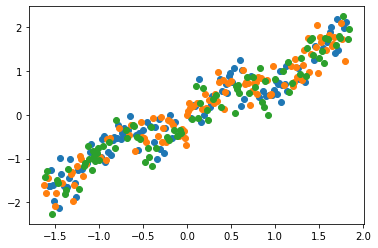

In [18]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);
plt.show()

In [19]:
# convert from nparray to Var
def nparray_to_Var(x):
  if x.ndim==1:
    y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
  else:
    y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
  return y
   
x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)


# Defining and initializing the network

The steps to create a feed forward neural network are the following:

1. **Number of hidden layer and hidden units**. We have to define the number of hidden units in each layer. The number of features in X and the output dimensionality (the size of Y) are given but the numbers in between are set by the researcher. Remember that for each unit in each layer beside in the input has a bias term.
2. **Activation functions** for each hidden layer. Each hidden layer in your list must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions that learn representations (features) from the data allowing us to learn from it. 
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of the exercise below. For now we will just use unit variance Gaussians.  

In order to make life easier for ourselves we define a DenseLayer class that takes care of initialization and the forward pass. We can also extend it later with print and advanced initialization capabilities. For the latter we have introduced a Initializer class.

Note that we use Sequence in the code below. A Sequence is an ordered list. This means the order we insert and access items are the same.

In [20]:
class Initializer:

  def init_weights(self, n_in, n_out):
    raise NotImplementedError

  def init_bias(self, n_out):
    raise NotImplementedError

In [21]:
import random

class NormalInitializer(Initializer):

  def __init__(self, mean=0, std=0.1):
    self.mean = mean
    self.std = std

  def init_weights(self, n_in, n_out):
    return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

  def __init__(self, weight=1.0, bias=0.0):
    self.weight = weight
    self.bias = bias

  def init_weights(self, n_in, n_out):
    return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(self.bias) for _ in range(n_out)]

In [22]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn
    
    def __repr__(self):    
        return f'\n Weights: {repr(self.weights)} \n Biases: {repr(self.bias)} \n'          # simply add '\n' for nice printing

    def parameters(self) -> Sequence[Var]:
      params = []
      for r in self.weights:
        params += r

      return params + self.bias

    def forward(self, inputs: Sequence[Var]) -> Sequence[Var]:
        assert len(self.weights) == len(inputs), "weights and inputs must match in first dimension"
        weights = self.weights
        out = []

        for j in range(len(weights[0])):
            node = self.bias[j]                                    # <- Insert code
            for i in range(len(inputs)):
                node += inputs[i]*weights[i][j]                    # <- Insert code --###-- a = w*x = w*z_{t-1} 
            node = self.act_fn(node)                               # z = h(a)
            out.append(node) 

        return out

## Exercise f) Complete the forward pass

In the code below we initialize a 1-5-1 network and pass the training set through it. The forward method in DenseLayer is not complete. It  just outputs zeros right now. The method forward should perform an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) on the input followed by an application of the activation function.

In [23]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):
  def forward_single(x, network):
    for layer in network:
        x = layer.forward(x)
    return x

  output = [ forward_single(input[n], network) for n in range(len(input))]
  return output

print(forward(x_train, NN))

[[Var(v=0.0089, grad=0.0000)], [Var(v=0.0178, grad=0.0000)], [Var(v=0.0016, grad=0.0000)], [Var(v=-0.0238, grad=0.0000)], [Var(v=0.0131, grad=0.0000)], [Var(v=0.0122, grad=0.0000)], [Var(v=0.0079, grad=0.0000)], [Var(v=-0.0057, grad=0.0000)], [Var(v=-0.0245, grad=0.0000)], [Var(v=0.0049, grad=0.0000)], [Var(v=0.0137, grad=0.0000)], [Var(v=-0.0151, grad=0.0000)], [Var(v=0.0110, grad=0.0000)], [Var(v=-0.0173, grad=0.0000)], [Var(v=0.0059, grad=0.0000)], [Var(v=0.0114, grad=0.0000)], [Var(v=0.0211, grad=0.0000)], [Var(v=0.0100, grad=0.0000)], [Var(v=0.0011, grad=0.0000)], [Var(v=0.0035, grad=0.0000)], [Var(v=-0.0113, grad=0.0000)], [Var(v=-0.0050, grad=0.0000)], [Var(v=0.0154, grad=0.0000)], [Var(v=0.0156, grad=0.0000)], [Var(v=-0.0066, grad=0.0000)], [Var(v=-0.0178, grad=0.0000)], [Var(v=0.0200, grad=0.0000)], [Var(v=0.0220, grad=0.0000)], [Var(v=0.0023, grad=0.0000)], [Var(v=0.0139, grad=0.0000)], [Var(v=-0.0224, grad=0.0000)], [Var(v=0.0033, grad=0.0000)], [Var(v=-0.0195, grad=0.0000)]

## Exercise g) Print all network parameters

Make a function that prints all the parameters of the network (weights and biases) with information about in which layer the appear. In the object oriented spirit you should introduce a method in the DenseLayer class to print the parameters of a layer. Hint: You can take inspiration from the corresponding method in Var. 

In [24]:
# Insert code here and in the DenseLayer class
def weight_printer(NN):
    '''Function to print the weights and bias of each layer'''

    for layer in range(len(NN)):
        print(f'Layer {layer}: {NN[layer]}')


weight_printer(NN=NN)

Layer 0: 
 Weights: [[Var(v=-0.2145, grad=0.0000), Var(v=0.1198, grad=0.0000), Var(v=0.0649, grad=0.0000), Var(v=-0.0087, grad=0.0000), Var(v=-0.1176, grad=0.0000)]] 
 Biases: [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)] 

Layer 1: 
 Weights: [[Var(v=-0.0315, grad=0.0000)], [Var(v=0.0528, grad=0.0000)], [Var(v=0.0923, grad=0.0000)], [Var(v=-0.0345, grad=0.0000)], [Var(v=-0.0730, grad=0.0000)]] 
 Biases: [Var(v=0.0000, grad=0.0000)] 



# Activation functions

To have a full definition of the neural network, we must define an activation function for every layer. Several activation functions have been proposed and have different characteristics. In the Var class we have already defined the rectified linear init (relu). 
 

## Exercise h) Add more activation functions

Implement the following activation functions in the Var class:

* Identity: $$\mathrm{identity}(x) = x$$
* Hyperbolic tangent: $$\tanh(x)$$
* Sigmoid (or logistic function): $$\mathrm{sigmoid}(x) = \frac{1}{1.0 + \exp(-x ) }$$  Hint: $\mathrm{sigmoid}'(x)= \mathrm{sigmoid}(x)(1-\mathrm{sigmoid}(x))$.  

Hint: You can seek inspiration in the relu method in the Var class.

## Anwser - see added code in Var class

## Visualization

Now that we have defined our activation functions we can visualize them to see what they look like:

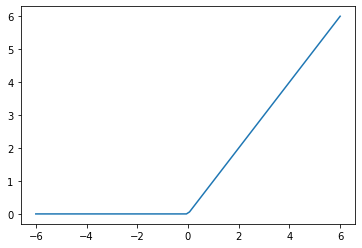

In [25]:
x = np.linspace(-6, 6, 100)

# convert from Var to ndarray  
def Var_to_nparray(x):
  y = np.zeros((len(x),len(x[0])))
  for i in range(len(x)):
    for j in range(len(x[0])):
      y[i,j] = x[i][j].v
  return y

# define 1-1 network with weight = 1 and relu activation 
NN = [ DenseLayer(1, 1, lambda x: x.relu(), initializer = ConstantInitializer(1.0)) ] 
y = Var_to_nparray(forward(nparray_to_Var(x), NN))

#y = Var_to_nparray(relu(nparray_to_Var(x)))
plt.plot(x,y)

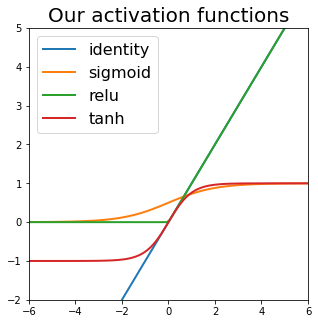

In [26]:
# Testing all activation layers

x = np.linspace(-6, 6, 100)
units = {
    "identity": lambda x: x.identity(),
    "sigmoid": lambda x: x.sigmoid(),   #<- uncomment before sharing
    "relu": lambda x: x.relu(),
    "tanh": lambda x: x.tanh()          #<- uncomment before sharing
}

plt.figure(figsize=(5, 5))
[plt.plot(x, Var_to_nparray(forward(nparray_to_Var(x), [DenseLayer(1, 1, unit, initializer = ConstantInitializer(1.0))]) ), label=unit_name, lw=2) for unit_name, unit in units.items()] # unit(nparray_to_Var(x))), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Our activation functions', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])
plt.show()

# Advanced initialization schemes

If we are not careful with initialization, the signals we propagate forward ($a^{(l)}$, $l=1,\ldots,L$) and backward ($\delta^l$, $l=L,L-1,\ldots,1$) can blow up or shrink to zero. A statistical analysis of the variance of the signals for different activation functions can be found in these two papers: [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf). 

The result of the analyses are proposals for how to make the initialization such that the variance of the signals (forward and backward) are kept approxmimatly constant when propagating from layer to layer. The exact expressions depend upon the non-linear activation function used. In Glorot initialization, the aim is to keep both the forward and backward variances constant whereas He only aims at keeping the variance in the forward pass constant.

We define $n_{in}$ and $n_{out}$ as the number of input units and output units of a particular layer. 

The Glorot initialization has the form: 

$$w_{ij} \sim N \bigg( 0, \, \frac{2 \alpha }{n_{in} + n_{out}} \bigg) \ . $$

where $N(\mu,\sigma^2)$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and $\alpha$ is a parameter that depends upon the activation function used. For $\tanh$, $\alpha=1$ and for Rectified Linear Unit (ReLU) activations, $\alpha=2$. (It is also possible to use a uniform distribution for initialization, see [this blog post](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init).) 

The He initialization is very similar

$$w_{ij} \sim N \bigg( 0, \, \frac{\alpha}{n_{in}} \bigg) \ . $$

## Exercise i) Glorot and He initialization
 
Using the Initializer class, implement functions that implement Glorot and He 

Explain briefly how you would test numerically that these initializations have the sought after property. Hint: See plots in Glorot paper.

Comment: If you want to be more advanced then try to make a universal initializer taking both the activation function and type (Glorot or He) as argument.

In [27]:
## Glorot
def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
  std = (2/(n_in + n_out))**(1/2)  # <- replace with proper initialization
  return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

## He
def DenseLayer_He_relu(n_in: int, n_out: int):
  std = ((2)/(n_in))**(1/2) # <- replace with proper initialization
  return DenseLayer(n_in, n_out, lambda x: x.relu(), initializer = NormalInitializer(std))


# OTHER 
# alpha = 1

# ## Glorot
# def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
#   std = np.sqrt((2*alpha)/(n_in + n_out))
#   return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))
# 
# alphaTanh = 2
# 
# ## He
# def DenseLayer_He_relu(n_in: int, n_out: int):
#   std = np.sqrt(alphaTanh/n_in)
#   # Corrected x.tanh() to x.relu(), since this function mentions relu
#   return DenseLayer(n_in, n_out, lambda x: x.relu(), initializer = NormalInitializer(std))

## Exercise j) Forward pass unit test

Write a bit of code to make a unit test that the forward pass works. This can be done by defining a simple network with for example all weights equal to one (using the ConstantInitializer method) and identity activation functions. 

Hints: Use the [assert](https://www.w3schools.com/python/ref_keyword_assert.asp), the nparray_to_Var and the Var_to_nparray commands. 

In [29]:
# Insert code here
NN = [
    DenseLayer(n_in=1, n_out=5, act_fn=lambda x: x.relu(), initializer=ConstantInitializer() ), 
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):
  def forward_single(x, network):
    for layer in network:
        x = layer.forward(x)
    return x

  output = [ forward_single(input[n], network) for n in range(len(input))]
  assert output!=input, 'your input goes right through...'
  return output

print(forward(x_train, NN))

[[Var(v=-0.2452, grad=0.0000)], [Var(v=-0.4929, grad=0.0000)], [Var(v=-0.0447, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=-0.3632, grad=0.0000)], [Var(v=-0.3357, grad=0.0000)], [Var(v=-0.2177, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=-0.1352, grad=0.0000)], [Var(v=-0.3789, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=-0.3042, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=-0.1627, grad=0.0000)], [Var(v=-0.3160, grad=0.0000)], [Var(v=-0.5833, grad=0.0000)], [Var(v=-0.2767, grad=0.0000)], [Var(v=-0.0290, grad=0.0000)], [Var(v=-0.0958, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=-0.4261, grad=0.0000)], [Var(v=-0.4300, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=-0.5519, grad=0.0000)], [Var(v=-0.6069, grad=0.0000)], [Var(v=-0.0644, grad=0.0000)], [Var(v=-0.3828, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=-0.0919, grad=0.0000)], [Var(v=0.0000, gr

# Loss functions

We are only missing a loss function to we need to define a loss function and its derivative with respect to the output of the neural network $y$

In [30]:
def squared_loss(t, y):
  
  # add check that sizes agree
  
  def squared_loss_single(t, y):
    Loss = Var(0.0)
    for i in range(len(t)): # sum over outputs
      Loss += (t[i]-y[i]) ** 2.0
    return Loss

  Loss = Var(0.0)
  for n in range(len(t)): # sum over training data
    Loss += squared_loss_single(t[n],y[n])
  return Loss

## Exercise j) Implement cross entropy loss

Insert code below to implement cross-entropy loss for general dimensionality of $t$. Use a logits formulation:
$$
\rm{Loss} = - \sum_i t_i \, log \, p_i 
$$
with $p$ given by the the softmax function in terms of the logits $h$:
$$
p_i = \frac{\exp(h_i)}{\sum_{i'} \exp(h_{i'} } .
$$
Inserting $p$ in the expression for the loss gives
$$
\rm{Loss} = - \sum_i t_i h_i + \rm{LogSumExp}(h) \ ,
$$
where 
$$
\rm{LogSumExp}(h) = \log \sum_i \exp h_i \ .
$$
This is true for $t$ being a one-hot vector. In practice you want to implement a [numerically stable](https://leimao.github.io/blog/LogSumExp/) version of LogSumExp. But we will not bother about that here.

Help: You can add these methods in the Var class:

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

In [31]:
def cross_entropy_loss(t, y):
    
    # Insert code here
    def log_sum_exp(t,y):
        Loss = Var(0.0)
        
        for i in range(len(t)):                 # sum over outputs
            Loss += -t[i]*np.log(y[i])          # Var(exp(y[i][0].v))
        return Loss
    
    Loss = Var(0.0)
    for n in range(len(t)):                     # sum over training data
        Loss += log_sum_exp(t[n], y[n])         # t[n][0]*y[n][0]

    return Loss

# Backward pass

Now the magic happens! We get the calculation of the gradients for free. Just do:

In [32]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = cross_entropy_loss(y_train, output)

Loss.backward()

and the gradients will be calculated:

In [33]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Layer 0 
 
 Weights: [[Var(v=0.0420, grad=-1531.9629), Var(v=-0.0672, grad=-551.5801), Var(v=0.0570, grad=1167.7398), Var(v=0.0395, grad=-1161.0568), Var(v=-0.0598, grad=-109.9215)]] 
 Biases: [Var(v=0.0000, grad=-1923.0918), Var(v=0.0000, grad=667.8804), Var(v=0.0000, grad=1465.8781), Var(v=0.0000, grad=-1457.4888), Var(v=0.0000, grad=133.0984)] 

Layer 1 
 
 Weights: [[Var(v=0.1140, grad=-563.8204)], [Var(v=0.0719, grad=515.7389)], [Var(v=-0.0869, grad=-765.5083)], [Var(v=0.0864, grad=-530.8007)], [Var(v=0.0143, grad=458.7786)]] 
 Biases: [Var(v=0.0000, grad=-7568.8088)] 



[None, None]

# Backward pass unit test

Above we used finite differences to test that Nanograd is actually doing what it is supposed to do. We can in principle try the same for the neural network. But we will trust that the test above is enough.

# Training and validation

We are ready to train some neural networks!

We initialize again:

In [34]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)

#output
Loss.backward()

weight_printer(NN=NN)

Layer 0: 
 Weights: [[Var(v=-0.0421, grad=-1.1948), Var(v=-0.0987, grad=13.6365), Var(v=-0.0265, grad=2.0090), Var(v=0.0623, grad=-6.3811), Var(v=-0.0090, grad=15.8247)]] 
 Biases: [Var(v=0.0000, grad=1.0857), Var(v=0.0000, grad=-12.3912), Var(v=0.0000, grad=-1.8255), Var(v=0.0000, grad=-5.4818), Var(v=0.0000, grad=-14.3796)] 

Layer 1: 
 Weights: [[Var(v=0.0127, grad=3.9769)], [Var(v=-0.1444, grad=9.3183)], [Var(v=-0.0213, grad=2.5027)], [Var(v=0.0631, grad=-6.2987)], [Var(v=-0.1676, grad=0.8537)]] 
 Biases: [Var(v=0.0000, grad=-1.0992)] 



and make an update:

We introduce a help function parameters to have a handle in all parameters in the network.

In [36]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

def parameters(network):
  params = []
  for layer in range(len(network)):
    params += network[layer].parameters()
  return params

def update_parameters(params, learning_rate=0.01):
  for p in params:
    p.v -= learning_rate*p.grad

def zero_gradients(params):
  for p in params:
    p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Network before update:
Layer 0 
 
 Weights: [[Var(v=-0.0421, grad=-1.1948), Var(v=-0.0987, grad=13.6365), Var(v=-0.0265, grad=2.0090), Var(v=0.0623, grad=-6.3811), Var(v=-0.0090, grad=15.8247)]] 
 Biases: [Var(v=0.0000, grad=1.0857), Var(v=0.0000, grad=-12.3912), Var(v=0.0000, grad=-1.8255), Var(v=0.0000, grad=-5.4818), Var(v=0.0000, grad=-14.3796)] 

Layer 1 
 
 Weights: [[Var(v=0.0127, grad=3.9769)], [Var(v=-0.1444, grad=9.3183)], [Var(v=-0.0213, grad=2.5027)], [Var(v=0.0631, grad=-6.2987)], [Var(v=-0.1676, grad=0.8537)]] 
 Biases: [Var(v=0.0000, grad=-1.0992)] 


Network after update:
Layer 0 
 
 Weights: [[Var(v=-0.0302, grad=-1.1948), Var(v=-0.2350, grad=13.6365), Var(v=-0.0466, grad=2.0090), Var(v=0.1261, grad=-6.3811), Var(v=-0.1673, grad=15.8247)]] 
 Biases: [Var(v=-0.0109, grad=1.0857), Var(v=0.1239, grad=-12.3912), Var(v=0.0183, grad=-1.8255), Var(v=0.0548, grad=-5.4818), Var(v=0.1438, grad=-14.3796)] 

Layer 1 
 
 Weights: [[Var(v=-0.0271, grad=3.9769)], [Var(v=-0.2376, grad

[None, None]

In [37]:
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

# Recommended hyper-parameters for 3-D: 
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients 
## of the activation functions.

In [38]:
# Initialize training hyperparameters
EPOCHS = 200
LEARN_R = 2e-3 

In [305]:
train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        


   0 ( 0.00%) Train loss: 101.422 	 Validation loss: 100.374
  10 ( 5.00%) Train loss: 19.778 	 Validation loss: 14.240
  20 (10.00%) Train loss: 14.431 	 Validation loss: 10.742
  30 (15.00%) Train loss: 14.015 	 Validation loss: 10.476
  40 (20.00%) Train loss: 13.662 	 Validation loss: 10.238
  50 (25.00%) Train loss: 13.153 	 Validation loss: 9.926
  60 (30.00%) Train loss: 12.670 	 Validation loss: 9.634
  70 (35.00%) Train loss: 12.389 	 Validation loss: 9.421
  80 (40.00%) Train loss: 12.220 	 Validation loss: 9.315
  90 (45.00%) Train loss: 12.079 	 Validation loss: 9.245
 100 (50.00%) Train loss: 11.995 	 Validation loss: 9.221
 110 (55.00%) Train loss: 11.949 	 Validation loss: 9.194
 120 (60.00%) Train loss: 11.923 	 Validation loss: 9.159
 130 (65.00%) Train loss: 11.909 	 Validation loss: 9.128
 140 (70.00%) Train loss: 11.902 	 Validation loss: 9.101
 150 (75.00%) Train loss: 11.897 	 Validation loss: 9.079
 160 (80.00%) Train loss: 11.895 	 Validation loss: 9.065
 170 (8

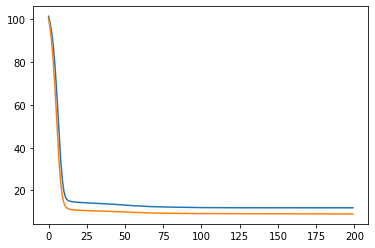

In [306]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

# Testing

We have kept the calculation of the test error separate in order to emphasize that you should not use the test set in optimization.

In [307]:
output_test = forward(x_test, NN)

Test loss:  9.842


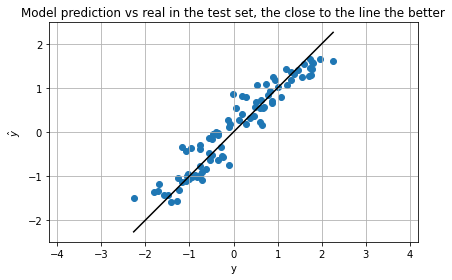

In [308]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

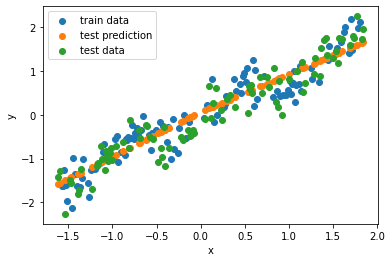

In [309]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

## Exercise k) Show overfitting, underfitting and just right fitting

Vary the architecture and other things to show clear signs of overfitting (=training loss significantly lower than test loss) and underfitting (=not fitting enoung to training data so that test performance is also hurt).

See also if you can get a good compromise which leads to a low validation loss. 

For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two separate.

_Insert written answer here._

## Anwser to k)

Generally, we overfit when our model fails to generalize well. This. happens when we do not regularize our model with (e.g. tune L1 and L2) and/or if the model sees the data too many times (too many epocs). On the other hand, our model underfits when it doesn't capture the logic and structure of the underlying process. Underfitting happens if we 'punish' the model too hard with strong regularization and/or to few epocs.


   0 ( 0.00%) Train loss: 106.501 	 Validation loss: 107.705
  10 (50.00%) Train loss: 93.380 	 Validation loss: 88.083
Test loss:  21.359


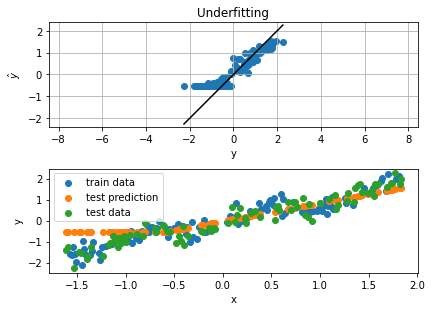

In [320]:
# Insert your code for getting overfitting, underfitting and just right fitting

################################################## Underfitting (UF()) ##################################################
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 3, lambda x: x.relu()),
    DenseLayer(3, 1, lambda x: x.identity())
]

# Initialize training hyperparameters
EPOCHS = 20
LEARN_R = 2e-3 

rain_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))

# store model predictions        
output_test_UF = forward(x_test, NN)


plt.figure(1)
plt.subplot(211)
plt.title('Underfitting')

y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test_UF));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
#plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))


x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.subplot(212)
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test_UF), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
    plt.show()
    
else:
    plt.subplot(212)
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test_UF), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
    plt.show()

   0 ( 0.00%) Train loss: 111.982 	 Validation loss: 97.640
  10 ( 2.00%) Train loss: 14.484 	 Validation loss: 10.966
  20 ( 4.00%) Train loss: 13.634 	 Validation loss: 10.231
  30 ( 6.00%) Train loss: 13.217 	 Validation loss: 9.909
  40 ( 8.00%) Train loss: 12.855 	 Validation loss: 9.624
  50 (10.00%) Train loss: 12.543 	 Validation loss: 9.382
  60 (12.00%) Train loss: 12.325 	 Validation loss: 9.201
  70 (14.00%) Train loss: 12.137 	 Validation loss: 9.082
  80 (16.00%) Train loss: 12.019 	 Validation loss: 8.979
  90 (18.00%) Train loss: 11.950 	 Validation loss: 8.922
 100 (20.00%) Train loss: 11.903 	 Validation loss: 8.886
 110 (22.00%) Train loss: 11.871 	 Validation loss: 8.866
 120 (24.00%) Train loss: 11.849 	 Validation loss: 8.856
 130 (26.00%) Train loss: 11.833 	 Validation loss: 8.849
 140 (28.00%) Train loss: 11.819 	 Validation loss: 8.843
 150 (30.00%) Train loss: 11.804 	 Validation loss: 8.835
 160 (32.00%) Train loss: 11.791 	 Validation loss: 8.827
 170 (34.0

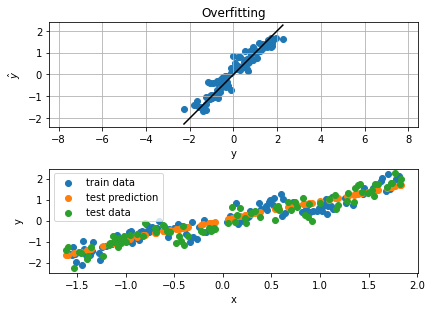

In [322]:
######################################### Overfitting #######################################

# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]

# Initialize training hyperparameters
EPOCHS = 500
LEARN_R = 2e-3 

rain_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))

# store model predictions        
output_test_UF = forward(x_test, NN)


plt.figure(1)
plt.subplot(211)
plt.title('Overfitting')

y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test_UF));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
#plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))


x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.subplot(212)
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test_UF), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
    plt.show()
    
else:
    plt.subplot(212)
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test_UF), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
    plt.show()

   0 ( 0.00%) Train loss: 112.576 	 Validation loss: 107.303
  10 ( 5.00%) Train loss: 37.478 	 Validation loss: 28.421
  20 (10.00%) Train loss: 18.586 	 Validation loss: 14.336
  30 (15.00%) Train loss: 15.003 	 Validation loss: 11.217
  40 (20.00%) Train loss: 12.773 	 Validation loss: 9.727
  50 (25.00%) Train loss: 12.355 	 Validation loss: 9.334
  60 (30.00%) Train loss: 12.174 	 Validation loss: 9.140
  70 (35.00%) Train loss: 12.077 	 Validation loss: 9.049
  80 (40.00%) Train loss: 12.033 	 Validation loss: 9.015
  90 (45.00%) Train loss: 12.006 	 Validation loss: 8.994
 100 (50.00%) Train loss: 11.979 	 Validation loss: 8.977
 110 (55.00%) Train loss: 11.960 	 Validation loss: 8.976
 120 (60.00%) Train loss: 11.937 	 Validation loss: 8.985
 130 (65.00%) Train loss: 11.927 	 Validation loss: 8.971
 140 (70.00%) Train loss: 11.921 	 Validation loss: 8.963
 150 (75.00%) Train loss: 11.916 	 Validation loss: 8.961
 160 (80.00%) Train loss: 11.912 	 Validation loss: 8.961
 170 (85

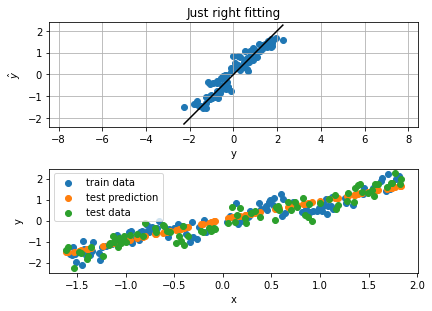

In [324]:
######## Just right fitting
NN = [
    DenseLayer(1, 16, lambda x: x.relu()),
    DenseLayer(16, 1, lambda x: x.identity())
]

# Initialize training hyperparameters
EPOCHS = 200
LEARN_R = 2e-3 

rain_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))

# store model predictions        
output_test_UF = forward(x_test, NN)


plt.figure(1)
plt.subplot(211)
plt.title('Just right fitting')

y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test_UF));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
#plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))


x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.subplot(212)
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test_UF), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
    plt.show()
    
else:
    plt.subplot(212)
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test_UF), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
    plt.show()

# Next steps - classification

It is straight forward to extend what we have done to classification. 

For numerical stability it is better to make softmax and cross-entropy as one function so we write the cross entropy loss as a function of the logits we talked about last week. 

Next week we will see how to perform classification in PyTorch.

## Exercise l) optional - Implement backpropagation for classification

Should be possible with very few lines of code. :-)

In [ ]:
# Just add code.

## Exercise m) optional - Introduce a NeuralNetwork class

The functions we applied on the neural network (parameters, update_parameters and zero_gradients) can more naturally be included as methods in a NeuralNetwork class. Make such a class and modify the code to use it. 

In [ ]:
# just add some code